# Time Series

https://m.blog.naver.com/nywoo19/221592466724

# Python for Traders and Investors -- Chapter 6

## 6.2 A simple backtest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

In [2]:
# Download the data for TripAdvisor 'TRIP'
pep = yf.download('TRIP')['Adj Close']

[*********************100%***********************]  1 of 1 completed


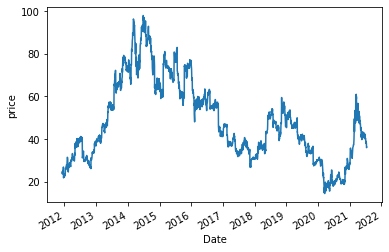

In [3]:
# Plotting the historical price data
pep.plot()
plt.ylabel('price')
plt.show()

__Buy and Hold strategy__

In [4]:
# Let's define some variables
# This indicates whether we have a position on or not
inpos = 0

# Hold for 60 days
hold_period = timedelta(60)

wait = 0

# This is the PnL
pnl = []
pos = []
time_in_trade = []

In [5]:
for date in pep.index:
    
    if inpos == 0 and wait == 2:
        entry_price = pep[date]
        open_time = date
        inpos = 1
        
    elif inpos == 1 and date-open_time >= hold_period:
        #Profit/loss for this trade
        p = pep[date] - entry_price
        pnl.append(p)
        inpos = 0
    
    elif inpos == 0 and wait < 2:
        wait += 1
        
    pos.append(inpos)

In [6]:
pnl[:3]

[6.162679672241211, 1.0315608978271484, 7.43433952331543]

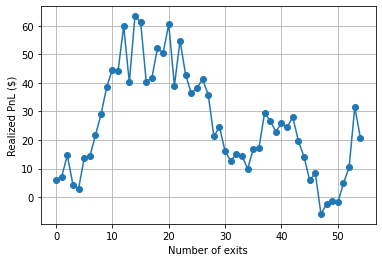

In [7]:
plt.plot(np.cumsum(pnl),'-o')
plt.xlabel('Number of exits')
plt.ylabel('Realized PnL ($)')
plt.grid()
plt.show()

## 6.3 Cointegration

In [8]:
import yfinance as yf

In [10]:
# Obtain the adjusted closing price
price_cl = yf.download(['EWC', 'EWA'])['Adj Close']

[*********************100%***********************]  2 of 2 completed


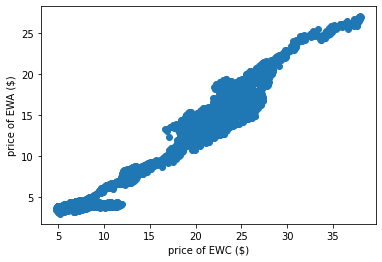

In [11]:
plt.scatter(price_cl['EWC'], price_cl['EWA'])
plt.xlabel('price of EWC ($)')
plt.ylabel('price of EWA ($)')
plt.show()

In [14]:
#!pip install statsmodels 

In [15]:
from statsmodels.tsa.stattools import coint

In [19]:
price_cl = price_cl.dropna()

In [20]:
coint_t, pvalue, crit = coint(price_cl['EWC'], price_cl['EWA'])

In [21]:
# t-statistic of unit-root test on residuals
coint_t

-3.8338016227280716

In [22]:
# p-value
pvalue

0.012212416746774445

In [23]:
# Critical values for the test statistic at the 1%, 5%, and 10% levels 
crit

array([-3.89817786, -3.33709926, -3.04512274])

## 6.4 Building the pairs trading strategy

In [24]:
# Download the data
ewa = yf.download('EWA', start='2011-01-01', end='2019-12-23')['Adj Close']
ewc = yf.download('EWC', start='2011-01-01', end='2019-12-23')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


__Train/test split__

In [25]:
ewa_train = ewa[:-500]
ewa_test = ewa[-500:]

ewc_train = ewc[:-500]
ewc_test = ewc[-500:]

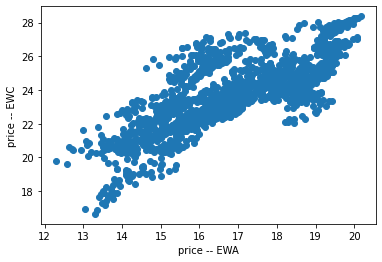

In [26]:
plt.plot(ewa_train, ewc_train,'o')
plt.xlabel('price -- EWA')
plt.ylabel('price -- EWC')
plt.show()

__Linear regression__

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
x = np.array([ewa_train]).T
y = np.array(ewc_train)

In [29]:
def LR(x, y):
    '''function for linear regression'''  
    lm = LinearRegression().fit(x, y) 
    a = lm.intercept_
    beta = lm.coef_
    
    xx = np.linspace(min(x), max(x),200) 
    yy = a + beta * xx
    return xx, yy, a, beta

In [30]:
def plot_LR(x, y):
    '''function that plots the regression with original points'''
    x_, y_, a, beta = LR(x,y)
    plt.plot(x, y,'o', ms=2)
    plt.plot(x_,y_)  # the regression line
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title('y = %f + %f*x'%(a, beta))
    return a, beta

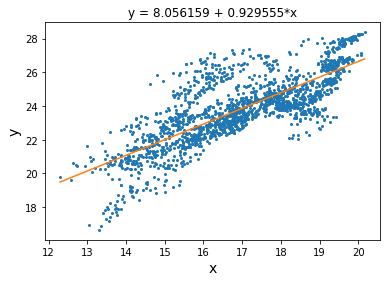

In [31]:
a, beta = plot_LR(x, y)

__Hedge ratio__

In [32]:
# The Hedge ratio would be
beta[0]

0.9295546142782346

In [33]:
# Intercept
a

8.056159060840704

__The spread__

The linear regression representation:

$$y = a + beta*x$$

$$spread = y - beta*x - a$$

In [34]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

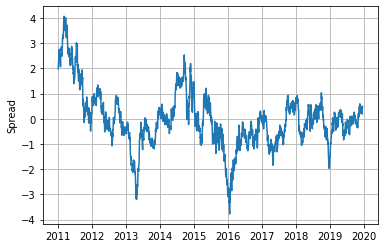

In [35]:
spread = ewc - beta[0]*ewa - a
plt.plot(spread)
plt.ylabel('Spread')
plt.grid()

__Generating the trading signal__

Setting the threshold

In [36]:
thresh = np.std(spread)*0.5

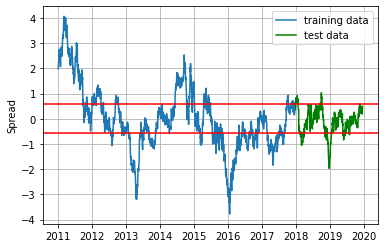

In [37]:
plt.plot(spread[:-500])
plt.plot(spread[-500:], color='g')
plt.legend(['training data', 'test data'])
plt.axhline(y = thresh, color='r')
plt.axhline(y = -thresh, color='r')
plt.ylabel('Spread')
plt.grid()
plt.show()

## 6.5 Constructing the backtest

Let's build our first backtest around this. The rules are: 
- When our spread rises more than one standard deviation above the mean, we buy EWA and sell EWC in the proportion of our hedge ratio
- When our spread falls to more than one standard deviation below the mean, we do the opposite.

In [38]:
# The trading signal
thresh = np.std(spread)*0.5

# This indicates whether we have a position on or not
inpos = 0

# This is the PnL per trade
pnl = []

# A list to save what position we have each day
pos = []

time_in_trade = []
exit_date = []

Next, we iterate through all the dates of the spreads. We use conditional statements _if, elif_ to determine which **state** we are in. The **state** of our system is determined by whether we are long the spread, short the spread or flat. 

In order to keep our first backtest simple, we assume that our portfolio components EWA and EWC are perfectly hedged according to the equation above and we just trade in and out of one-lots of the spread.

In [39]:
for date in spread.index:
    
    if spread[date] > thresh and not inpos:
        '''Entry Short Spread'''
        entry_price = spread[date]
        open_time = date
        inpos = -1
        
    elif spread[date] < 0 and inpos == -1:
        '''Exit Short Spread'''
        p =  entry_price - spread[date]
        pnl.append(p)
        inpos = 0
        time_in_trade.append((date-open_time).days)
        exit_date.append(date)
        print('Exit short:',sum(pnl))
        
    elif spread[date] < -thresh and not inpos:
        '''Entry Long Spread'''
        entry_price = spread[date]
        open_time = date
        inpos = 1
        
    elif spread[date] > 0 and inpos == 1:
        '''Exit Long Spread'''
        p = spread[date] - entry_price
        pnl.append(p)
        inpos = 0
        time_in_trade.append((date-open_time).days)
        exit_date.append(date)
        print('Exit long:',sum(pnl))  
        
    pos.append(inpos)

Exit short: 2.1308504270431623
Exit short: 2.7453991389883345
Exit short: 3.413594669224258
Exit long: 4.1310710180374866
Exit short: 4.986970888436337
Exit long: 5.676818870159456
Exit long: 6.454733152603458
Exit short: 7.145388772918135
Exit long: 7.7694435445528605
Exit short: 8.501328262532628
Exit short: 9.471239286286174
Exit short: 10.123178955772277
Exit long: 10.969596040826262
Exit short: 11.83249986335182
Exit long: 12.797384067041843
Exit long: 13.681153104957183
Exit short: 14.577003666865444
Exit long: 15.188298808402145
Exit short: 15.872241731426747
Exit long: 16.49610711642999
Exit long: 17.189367878007268


That's it, our first relative value backtest. Let's plot the PnL curve:

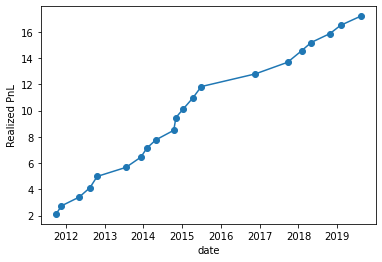

In [40]:
profit_per_trade = pd.Series(pnl)
profit_per_trade.index = exit_date

plt.plot(np.cumsum(profit_per_trade),'-o')
plt.xlabel('date')
plt.ylabel('Realized PnL')
plt.show()

## 6.6 Strategy analysis (1)

The above analysis seems really simple and obvious but actually, there is a lot more to do and understand in order to judge if this strategy is worthwhile running. There are a wide range of metrics that we can use to characterise our performance, one of them is PnL. 

Next, we calculate our daily PnL curve from the prices and positions. Note, that we use the shift(-1) function, which shifts the price changes to the left, so we end up with the correct value being multiplied to the positions. 
Small mistakes in this can dramatically change the results of your work and it is important to be really careful with implementing these metrics. We can test the validity of our calculation by plotting the daily pnl and comparing it with the values of the trade-based realised PnL calculation from above. 

In [41]:
# move the 'pos' list down by 1 element, by padding
# a 0 at the start:
pos1 = [0] + pos 
daily_pnl = spread.diff()*pos1[:-1]

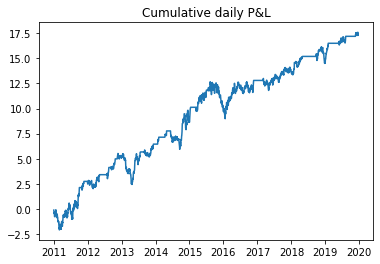

In [42]:
# Cumulative daily P&L
cum_daily_pnl = np.cumsum(daily_pnl)

plt.plot(cum_daily_pnl)
plt.title('Cumulative daily P&L')
plt.show()

In [43]:
def plot_2figs(data1, data2, label_1, label_2):
    fig=plt.figure(figsize=(10,6))
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(data1, color='k')
    ax.set_xlim('2011', '2020')
    ax.set_ylim(-3, 20)
    ax.grid()
    ax.set_ylabel(label_1, fontsize=14)

    ax2.plot(data2, 'go-')
    ax2.set_xlim('2011', '2020')
    ax2.set_ylim(-3, 20)
    ax2.set_ylabel(label_2, color='g', fontsize=14)
    ax2.yaxis.set_label_position('right') 
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.tick_params(colors="g")
    plt.show()

In [44]:
# Cumulative profit per trade
cum_p_per_trade = np.cumsum(profit_per_trade)

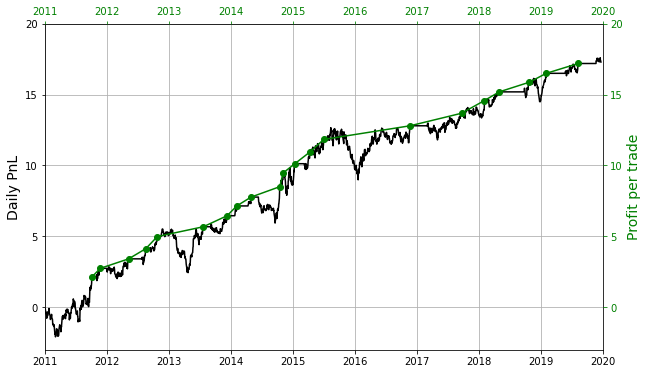

In [45]:
# Plotting them on the same chart
plot_2figs(cum_daily_pnl, cum_p_per_trade, 'Daily PnL', 'Profit per trade')

__Sharpe ratio__

In [46]:
# Portfolio size ($): 
portfolio_size = ewc[0] + beta[0]*ewa[0]

# Daily return
daily_ret = daily_pnl/portfolio_size

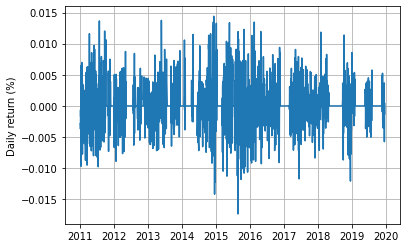

In [47]:
plt.plot(daily_ret)
plt.ylabel('Daily return (%)')
plt.grid()
plt.show()

In [48]:
# Annualised Sharpe ratio
sharpe = np.mean(daily_ret)/np.std(daily_ret)*np.sqrt(252)
sharpe

0.9036135640455129

## 6.7 Strategy analysis (2)
__Sortino ratio__

_The Sortino ratio is similar to the Sharpe ratio but it only regards the standard deviation of the negative returns. This avoids being penalised for excessive positive returns as it is the case for the Sharpe ratio and it may in some cases be a better metric._

In [49]:
Sortino = np.mean(daily_ret)/np.std(daily_ret[daily_ret<0])*np.sqrt(252)
Sortino

1.2392504936822124

__Drawdown__

$$d = \frac{cumRet}{runningMax} - 1$$

In [50]:
def drawdown(ret):
    cum_ret = np.cumprod(ret+1)
    running_max = np.fmax.accumulate(cum_ret)    
    # Ensure the value never drops below 1
    running_max[running_max<1] = 1
    
    d = cum_ret/running_max - 1    
    return d

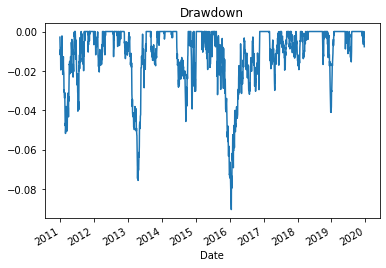

In [51]:
drawdown(daily_ret).plot()
plt.title('Drawdown')
plt.show()

__Value at Risk (VaR)__

VaR measures how much the investor might lose in a single day (or month, or year), in a worst case scenario, given a specified confidence interval, usually 95% or 99%.

In [52]:
from scipy.stats import norm

In [53]:
def VaR(P, c, lkbk, rets):
    # c: confidence interval
    # P: portfolio value
    # lkbk: lookback window
    mu = np.mean(rets[-lkbk:])
    sigma = np.std(rets[-lkbk:])
    alpha = norm.ppf(1-c, mu, sigma)
    return round(P - P*(alpha + 1))    

In [54]:
c = 0.95
P = 1e6

In [55]:
print('With {} confidence, we expect that our worst daily loss will not exceed ${} on our ${} portfolio.'.
      format(c, VaR(P, c, 200, daily_ret),P))

With 0.95 confidence, we expect that our worst daily loss will not exceed $2642 on our $1000000.0 portfolio.


__Histogram of Holding times__

This will give us and idea on how patient we have to be with our strategy.

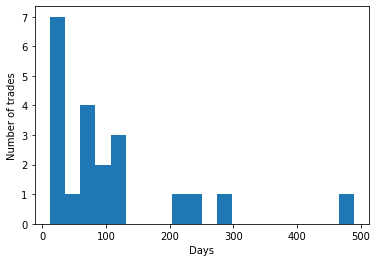

In [56]:
plt.hist(time_in_trade, bins=20)
plt.xlabel('Days')
plt.ylabel('Number of trades')
plt.show()

__Beta__

In [58]:
# Download the data for S&P500
benchmark = yf.download('SPY', start='2011-01-01', end='2019-12-23')['Adj Close']
# Benchmark returns
benchmark_r = benchmark.pct_change()

# Correlation between strategy return and benchmark return
daily_ret.corr(benchmark_r)

[*********************100%***********************]  1 of 1 completed


-0.048728765499567145

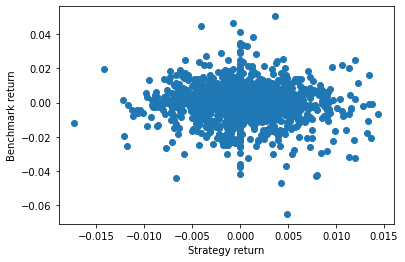

In [59]:
plt.scatter(daily_ret, benchmark_r)
plt.xlabel('Strategy return')
plt.ylabel('Benchmark return')
plt.show()